Load packages

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from gensim.models import Word2Vec
from gensim.models import word2vec
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import spacy
import en_core_web_sm
from random import sample
import numpy as np
from collections import Counter
import nltk

from nltk.util import ngrams
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore

### Load, examine, and clean files

In [2]:
df=pd.read_pickle('news_chicago_il.pkl')
#df=pickle.load(f)

In [3]:
df.columns.values

array(['crawled_date', 'language', 'text', 'title'], dtype=object)

In [4]:
df.shape

(177325, 4)

Drop articles that are teh same. Having similar articles would affect word counts

In [5]:
dat=df.drop_duplicates(subset='title', keep="last")

In [6]:
dat=dat.drop_duplicates(subset='text', keep="last")

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khristine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/khristine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/khristine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Combine title and article body, sometimes title contains relevant information.

In [9]:
#Concatenate title and aritcle body
dat['title_body']=dat['title'].str.cat(dat['text'], sep=" ")

Create a new column with cleaned title_body. I'll keep the original column as well, since the formatting helps with NER used later.

In [10]:
#lowercase
dat['cleaned_titlebody'] = dat['title_body'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#remove punctuation
dat['cleaned_titlebody'] = dat['cleaned_titlebody'].str.replace('[^\w\s]','')

#remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
dat['cleaned_titlebody'] = dat['cleaned_titlebody'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#lemmatization
from textblob import Word
dat['cleaned_titlebody'] = dat['cleaned_titlebody'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

Because of the time span used in these articles, many mention COVID. Since population has been declining for years, and COVID19 only recently appeared, it's safe to remove articles menitoning this. Additioanlly, since the language regarding COVID is quite specific, keywords are an easy option to filter.

In [11]:
str_rm=("covid","covid19","covid 19", "cv19", "coronavirus", "corona", "pandemic", "wuhan", "sanitize", "stayathome", "shelterinplace", "stay at home", "shelter in place", "social distance", "social distancing", "restore illinois", "face mask", 'facemask')

dat=dat[dat.cleaned_titlebody.apply(
        lambda txt: not any([str_rm in txt for str_rm in str_rm])
    )]

Left with 108,176 articles

In [12]:
dat.shape

(108176, 6)

### Add sentiment

I started by using an off-the-shelf package. However, when I looked at the sentiment of the articles by topic, almost all of theme were neutral. It seemed like this package was not a good option. A custom model is built later.

In [13]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [14]:
text=str(dat['cleaned_titlebody'])
#dat['score'] = dat['cleaned_titlebody'].apply(lambda text:analyzer.polarity_scores(str(text)))
dat['positive']=dat['cleaned_titlebody'].apply(lambda text:analyzer.polarity_scores(str(text))['pos'])
dat['negative']=dat['cleaned_titlebody'].apply(lambda text:analyzer.polarity_scores(str(text))['neg'])
dat['neutral']=dat['cleaned_titlebody'].apply(lambda text:analyzer.polarity_scores(str(text))['neu'])
dat['compound']=dat['cleaned_titlebody'].apply(lambda text:analyzer.polarity_scores(str(text))['compound'])

In [15]:
dat.describe()


positive       negative        neutral       compound
count  108176.000000  108176.000000  108176.000000  108176.000000
mean   0.121606       0.067714       0.810682       0.345528     
std    0.100014       0.088343       0.121779       0.698754     
min    0.000000       0.000000       0.124000      -1.000000     
25%    0.033000       0.000000       0.730000       0.000000     
50%    0.113000       0.034000       0.806000       0.612400     
75%    0.181000       0.100000       0.898000       0.974700     
max    0.800000       0.844000       1.000000       1.000000

### Word Frequencies

EDA, looking at top unigrams, bigrams, trigrams, and most similar words the top unigrams. 

In [16]:
from nltk.tokenize import word_tokenize
words=nltk.word_tokenize(str(dat['cleaned_titlebody']))

In [18]:
fdist = nltk.FreqDist(words)
fdist.most_common(10)

[('bankruptcy', 677),
 ('chicago', 143),
 ('chapter', 89),
 ('united', 83),
 ('state', 78),
 ('estate', 69),
 ('new', 66),
 ('bidding', 62),
 ('real', 61),
 ('illinois', 48)]

In [19]:
bigram = nltk.bigrams(words)
fdist_bi = nltk.FreqDist(bigram)
fdist_bi.most_common(10)

[(('united', 'state'), 57),
 (('real', 'estate'), 56),
 (('bankruptcy', 'bankruptcy'), 39),
 (('bankruptcy', 'bidding'), 31),
 (('chapter', '7'), 27),
 (('bankruptcy', 'lawyer'), 25),
 (('estate', 'bidding'), 23),
 (('bankruptcy', 'real'), 22),
 (('7', 'bankruptcy'), 21),
 (('bankruptcy', 'court'), 21)]

In [20]:
trigram = nltk.trigrams(words)
fdist_tri = nltk.FreqDist(trigram)
fdist_tri.most_common(10)

[(('real', 'estate', 'bidding'), 23),
 (('bankruptcy', 'real', 'estate'), 22),
 (('chapter', '7', 'bankruptcy'), 20),
 (('united', 'state', 'bankruptcy'), 14),
 (('real', 'estate', 'transaction'), 14),
 (('bankruptcy', 'bidding', 'training'), 13),
 (('chapter', '13', 'bankruptcy'), 13),
 (('nursing', 'home', 'abuse'), 13),
 (('april', '27', '2020'), 12),
 (('united', 'state', 'real'), 11)]

Similar words to most frequest unigrams

In [21]:
def build_corpus(data):
    corpus=[]
    for col in ['cleaned_titlebody']:
        for sentence in data[col].iteritems():
            word_list=sentence[1].split(" ")
            corpus.append(word_list)
    return corpus

In [22]:
corpus=build_corpus(dat)

In [23]:
model=word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

In [24]:
model.most_similar('bankruptcy')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bidding', 0.5422810912132263),
 ('delaware', 0.5190615057945251),
 ('fl', 0.487924724817276),
 ('louisiana', 0.4706118702888489),
 ('mi', 0.4526817500591278),
 ('nj', 0.4399610161781311),
 ('ne', 0.43733441829681396),
 ('connecticut', 0.4299091696739197),
 ('ga', 0.42124560475349426),
 ('montana', 0.4137565493583679)]

In [25]:
model.most_similar('chicago')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('downtown', 0.521805465221405),
 ('announces', 0.5117571353912354),
 ('2020', 0.49974343180656433),
 ('lori', 0.45709511637687683),
 ('shutterstock', 0.4549406170845032),
 ('chicagoans', 0.44142091274261475),
 ('pst', 0.43798375129699707),
 ('city', 0.43175461888313293),
 ('loop', 0.4276798367500305),
 ('chinatown', 0.4241487383842468)]

In [26]:
model.most_similar('chapter')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bankruptcy', 0.38729649782180786),
 ('adhesive', 0.3848406672477722),
 ('exhibit', 0.37922415137290955),
 ('8', 0.37421953678131104),
 ('vol', 0.3705313503742218),
 ('feb', 0.36476197838783264),
 ('global', 0.36351874470710754),
 ('6', 0.35426878929138184),
 ('overview', 0.34752342104911804),
 ('walton', 0.3463541269302368)]

In [27]:
model.most_similar('united')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('subsidiary', 0.5066034197807312),
 ('internationally', 0.5041580200195312),
 ('warrior', 0.5038946866989136),
 ('golden', 0.47988754510879517),
 ('europe', 0.43858712911605835),
 ('operates', 0.4353103041648865),
 ('asia', 0.433091938495636),
 ('headquartered', 0.4307061433792114),
 ('regulated', 0.42476460337638855),
 ('canada', 0.41985636949539185)]

In [28]:
model.most_similar('state')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('statewide', 0.5254415273666382),
 ('legislative', 0.4924209415912628),
 ('legislature', 0.4898531138896942),
 ('illinois', 0.4871301054954529),
 ('nation', 0.473556250333786),
 ('legislator', 0.4732620418071747),
 ('springfield', 0.46682509779930115),
 ('taxpayer', 0.4593829810619354),
 ('government', 0.4571070969104767),
 ('enacted', 0.4565545916557312)]

In [29]:
model.most_similar('estate')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('relating', 0.598838210105896),
 ('midwest', 0.58460932970047),
 ('housewife', 0.5776292085647583),
 ('multifamily', 0.44791096448898315),
 ('realty', 0.4376325011253357),
 ('suburban', 0.4299485385417938),
 ('part', 0.40528005361557007),
 ('commence', 0.3703335225582123),
 ('nickel', 0.36756932735443115),
 ('remax', 0.36106374859809875)]

In [30]:
model.most_similar('new')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('newly', 0.4276384115219116),
 ('newest', 0.39910972118377686),
 ('knicks', 0.398656964302063),
 ('launching', 0.3833560645580292),
 ('next', 0.37254250049591064),
 ('expansion', 0.3668617606163025),
 ('already', 0.35400155186653137),
 ('introduce', 0.350099116563797),
 ('yankee', 0.3493505120277405),
 ('underway', 0.3467157185077667)]

In [31]:
model.most_similar('bidding')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bankruptcy', 0.5422810912132263),
 ('auction', 0.47545063495635986),
 ('spring', 0.39529988169670105),
 ('tx', 0.3874785304069519),
 ('rio', 0.3718611001968384),
 ('procurement', 0.3642961382865906),
 ('triplea', 0.3621387481689453),
 ('licensing', 0.35742926597595215),
 ('financing', 0.3526535630226135),
 ('rhode', 0.344275563955307)]

In [32]:
model.most_similar('real')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('hoffman', 0.6810261607170105),
 ('smartframe', 0.35615116357803345),
 ('reciprocity', 0.354295551776886),
 ('midwest', 0.34137141704559326),
 ('part', 0.31843650341033936),
 ('brokerage', 0.31615132093429565),
 ('name_lcid', 0.3080679476261139),
 ('xsltemplate', 0.30659908056259155),
 ('selectlcid', 0.3051939010620117),
 ('xslparam', 0.30483657121658325)]

In [33]:
model.most_similar('illinois')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ill', 0.5576179623603821),
 ('springfield', 0.5539016723632812),
 ('carbondale', 0.5207570195198059),
 ('heraldreviewcom', 0.4908135235309601),
 ('uis', 0.48723310232162476),
 ('state', 0.48713013529777527),
 ('edwardsville', 0.4832320213317871),
 ('siu', 0.45636066794395447),
 ('morehead', 0.45417359471321106),
 ('instate', 0.43193644285202026)]

Also add a couple specifically related to 'population'. I will subset for 'population related comments later. THis will be helpful to identify which keywords to use when subsetting.

In [34]:
model.most_similar('population')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('demographic', 0.6776423454284668),
 ('migration', 0.6433116793632507),
 ('disparity', 0.6011158227920532),
 ('decline', 0.5996161699295044),
 ('census', 0.5740386247634888),
 ('declining', 0.55619215965271),
 ('historically', 0.5362598299980164),
 ('poverty', 0.5361571311950684),
 ('income', 0.5342130064964294),
 ('economic', 0.5209722518920898)]

In [35]:
model.most_similar('decline')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('declining', 0.8345119953155518),
 ('recession', 0.7037687301635742),
 ('dramatically', 0.7012501955032349),
 ('steadily', 0.6644927263259888),
 ('risen', 0.6482783555984497),
 ('increase', 0.6318000555038452),
 ('significantly', 0.6293047070503235),
 ('slower', 0.6037561297416687),
 ('population', 0.5996161699295044),
 ('growth', 0.5977382659912109)]

In [36]:
model.most_similar('migration')

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('population', 0.6433115601539612),
 ('migrant', 0.5539855360984802),
 ('economic', 0.5405035018920898),
 ('decline', 0.5073210597038269),
 ('economy', 0.5069081783294678),
 ('demographic', 0.503481388092041),
 ('historically', 0.48746344447135925),
 ('recession', 0.48106300830841064),
 ('poland', 0.47413381934165955),
 ('attracting', 0.4704778492450714)]

### Visualizations

I used wordclouds here. I've tried some other visualizations like t-sne, but it seems that wordclouds are the easiest to interpret ina business setting.

In [37]:
def build_corpus(data):
    corpus=[]
    for col in ['cleaned_titlebody']:
        for sentence in data[col].iteritems():
            word_list=sentence[1].split(" ")
            corpus.append(word_list)
    return corpus

In [38]:
text = str(dat.cleaned_titlebody)

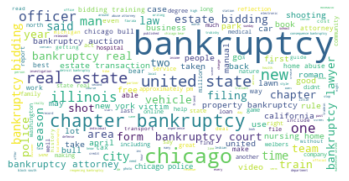

In [39]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### LDA

I start by trying to identify the # of topics for LDA. I did so by computing the coherence value at each n number of topics. The optimal number of topics based on the plot was 10 (max number of topics before coherence value plateaus). Ideally I would've also liked to check with LDAVis but it took too long to run.

In [409]:
list_of_text = list(dat["cleaned_titlebody"])

In [410]:
doc_clean = [doc.split() for doc in list_of_text]  

In [414]:
def prepare_LDA_data(corpus):
    """
    Returns objects to build lda model

    Parameters:
    -----------
    texts : text contents of documents assembled into a list

    Returns:
    -----------
    corpus: 
    dictionary : the term dictionary of our courpus
    doc_term_matrix : list of documents (corpus) into Document Term Matrix using dictionary

    Dependencies:
    -----------
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. 
    dictionary = corpora.Dictionary(corpus)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

    return corpus, dictionary, doc_term_matrix

In [415]:
corpus, dictionary, doc_term_matrix = prepare_LDA_data(doc_clean)

In [416]:
# Create Dictionary
id2word = corpora.Dictionary(doc_clean)

# Create Corpus
texts = doc_clean

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]



In [417]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [418]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=doc_clean, start=2, limit=100, step=6)

In [419]:
import matplotlib.pyplot as plt
%matplotlib inline

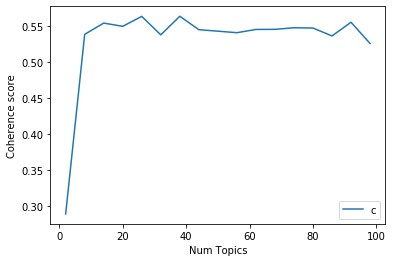

In [420]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Create LDA model with 10 topics

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer(max_df=0.8, min_df=2)
sk_doc_term_matrix=count_vect.fit_transform(dat["cleaned_titlebody"].values.astype('U'))

In [67]:
from sklearn.decomposition import LatentDirichletAllocation
LDA=LatentDirichletAllocation(n_components=10, random_state=42)
%time LDA.fit(sk_doc_term_matrix)

CPU times: user 38min 4s, sys: 6.79 s, total: 38min 11s
Wall time: 9min 40s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [68]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic#{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic#0:
['illinois', 'would', 'law', 'one', 'marijuana', 'year', 'people', 'state', 'chicago', 'said']


Top 10 words for topic#1:
['park', 'community', 'year', 'bear', 'school', '2020', 'live', 'city', 'new', 'chicago']


Top 10 words for topic#2:
['information', 'need', 'chicago', 'work', 'company', 'customer', 'experience', 'job', 'business', 'service']


Top 10 words for topic#3:
['county', 'shooting', 'officer', 'illinois', 'pm', 'shot', 'man', 'said', 'police', 'chicago']


Top 10 words for topic#4:
['average', 'work', 'tool', 'inc', 'price', 'rating', 'quarter', 'stock', 'company', 'share']


Top 10 words for topic#5:
['day', 'new', 'show', 'also', 'make', 'time', 'get', 'like', 'one', 'chicago']


Top 10 words for topic#6:
['last', 'first', 'season', 'win', 'basketball', 'team', 'state', 'point', 'game', 'illinois']


Top 10 words for topic#7:
['reciprocity', 'logo', 'property', 'data', 'information', 'sale', 'may', 'broker', 'real', 'estate']


Top 10 words f

Assign topic with highest probability of being associated with the document to the document as a new column.

In [69]:
topic_values=LDA.transform(sk_doc_term_matrix)
topic_values.shape

(108176, 10)

In [70]:
dat['topic']=topic_values.argmax(axis=1)

In [71]:
dat['topic']='topic'+dat['topic'].astype(str)

Count the number of topics in the whole article.

In [78]:
dat['topic'].value_counts()

topic5    20452
topic1    15283
topic3    14199
topic0    12935
topic8    10551
topic2    10287
topic6    7804 
topic9    7028 
topic7    6131 
topic4    3506 
Name: topic, dtype: int64

Look at average sentiment (positive, neutral, negative) for each topic. Based on this, pretty much every topic is the same, likely because the sentiment model doesn't really work for this use case

In [79]:
dat.groupby(['topic'])['positive'].mean()

topic
topic0    0.114902
topic1    0.100293
topic2    0.176519
topic3    0.062217
topic4    0.147006
topic5    0.181938
topic6    0.102866
topic7    0.027220
topic8    0.146975
topic9    0.096731
Name: positive, dtype: float64

In [80]:
dat.groupby(['topic'])['negative'].mean()

topic
topic0    0.125037
topic1    0.024054
topic2    0.038841
topic3    0.156747
topic4    0.016878
topic5    0.059055
topic6    0.050873
topic7    0.000635
topic8    0.061992
topic9    0.055899
Name: negative, dtype: float64

In [81]:
dat.groupby(['topic'])['neutral'].mean()

topic
topic0    0.760065
topic1    0.875653
topic2    0.784644
topic3    0.781043
topic4    0.836105
topic5    0.759008
topic6    0.846258
topic7    0.972144
topic8    0.791032
topic9    0.847382
Name: neutral, dtype: float64

I usually like to look at sample of comments for each LDA topic. Looking the the top keywords per topic usually isn't enough. Despite the techniques, sometimes some manually reading is required. I also find that business partners love seeing a sample of comments or verbatim, so I can grab some particularly relevant ones here.

In [251]:
#['illinois', 'would', 'law', 'one', 'marijuana', 'year', 'people', 'state', 'chicago', 'said']
dat['title'][dat['topic']=="topic0"].tail(10)

177054    Kanye West Buys Back Mum’s Former Home In Chicago                                                              
177064    Just got speeding ticket in mail, fine =$100. I'd like to fight it. Violation codespeed violation 11+. Chicago.
177078    Refund Rejection: Vrbo Customers Shut Down in Battle to Get Money Back – NBC Chicago                           
177082    Kanye West Buys His Chicago Childhood House                                                                    
177117    Respirators N95 Mask - Naperville, Illinois, United States                                                     
177138    Kanye West Purchases Childhood Chicago Home For $225K & Plans On Renovating                                    
177182    EXCLUSIVE: IL Governor Lockdown OVERRULED! Rep. Darren Bailey Reveals Plan To Reopen Illinois                  
177186    Kanye West Buys Back Childhood Home in Chicago                                                                 
177188    Kanye West Has

In [85]:
#['park', 'community', 'year', 'bear', 'school', '2020', 'live', 'city', 'new', 'chicago']
dat['title'][dat['topic']=="topic1"].head(10)

35     A girls' choir at the Bosnian Islamic Cultural Center in Chicago gather after performing for the congregation..jpg IllinoisMuslims                                                                                 
37     Travel home | direct flight from Madrid to Chicago | quirkyjazz                                                                                                                                                    
40     2020 Chicago Bears Schedule Release : NotTimAndEric                                                                                                                                                                
46     Airfare Deal: Chicago - Sofia, Bulgaria. $453 (Basic Economy) / $583 (Regular Economy). Roundtrip, including all Taxes                                                                                             
89     Virtually Visiting Chicago Museums                                                                                   

In [94]:
#['information', 'need', 'chicago', 'work', 'company', 'customer', 'experience', 'job', 'business', 'service']
dat['title'][dat['topic']=="topic2"].tail(10)

177104    The Value of Library Reference : You Decide | Chicago Librarian                                              
177105    Chicago attorney faced with reciprocal law license suspension for fatal crash                                
177118    Request for Information Polymerase Chain Reaction (PCR) Testing Operations in the State of Illinois          
177146    Masters in Computer Science at the College of Chicago Offers the Most Effective Sources For Occupation Growth
177159    Illinois Is BROKE! … Read The Article                                                                        
177236    Bug #12628 (In Progress): chicago: smatch and NULL pointer errors                                            
177262    Pros in Computer Science at the College of Chicago Delivers the Most Useful Resources For Job Growth         
177283    MOVEAUTO,com, a leading transportation company to Expand into Chicago, Illinois                              
177292    Elgin Volkswagen Encourages Dr

In [88]:
#['county', 'shooting', 'officer', 'illinois', 'pm', 'shot', 'man', 'said', 'police', 'chicago']
dat['title'][dat['topic']=="topic3"].head(10)

2      Foto Friday: Alton, Illinois                                                                                                                                                                             
5      4 Dead, at Least 17 Injured in Shootings Across Chicago                                                                                                                                                  
10     7 Chicago officers injured in altercation at storage center - SFGate                                                                                                                                     
104    4 dead, 18 hurt in Chicago weekend shootings                                                                                                                                                             
140    Bloomingdale & Mason - Caller says two males are selling heroin and one was seen with a gun. Chicago Chicago,Illinois - News from Illinois, source of news fr

In [99]:
#['average', 'work', 'tool', 'inc', 'price', 'rating', 'quarter', 'stock', 'company', 'share']
dat['title'][dat['topic']=="topic4"].head(20)

250     Tradition Asset Management LLC Has $1.67 Million Holdings in Illinois Tool Works Inc. (NYSE:ITW)
251     Illinois Tool Works Inc. (NYSE:ITW) Shares Sold by River Wealth Advisors LLC                    
252     Bigelow Investment Advisors LLC Sells 400 Shares of Illinois Tool Works Inc. (NYSE:ITW)         
290     Chicago Rivet & Machine Co. (AMEX:CVR) CVR Energy's Stock Is Trading Lower Today                
307     Prudential PLC Lowers Stake in Illinois Tool Works Inc. (NYSE:ITW)                              
312     Illinois Tool Works Inc. (NYSE:ITW) Director Buys $250,724.25 in Stock                          
315     Illinois Tool Works Inc. (NYSE:ITW) CEO Buys $998,046.00 in                                     
320     Illinois Tool Works Inc. (NYSE:ITW) CEO Buys $998,046.00 in Stock                               
435     Chicago Mercantile Exchange (CME) sees 43% increase in Bitcoin futures trading                  
453     Illinois Tool Works Inc. (NYSE:ITW) Shares Sold

In [84]:
#['day', 'new', 'show', 'also', 'make', 'time', 'get', 'like', 'one', 'chicago']
dat['title'][dat['topic']=="topic5"].head(10)

8      You know I had to do it >:DI love Chicago so fricking much,...                                                                                 
24     Real reason Nigerian Vblogger, A&R, Tolani Baj moved from Chicago to Lagos                                                                     
36     BASED ON TRUE EVENTS CHICAGO GHETTO - 11:30pm - W                                                                                              
38     Trip beginning | Chicago to Dublin to Lisbon | quirkyjazz                                                                                      
44     Hello fro Chicago                                                                                                                              
56     Rec-rec chicago deep dish... delish!!! : pelletgrills                                                                                          
87     NUP_165375_0001.jpg | CHICAGO FIRE -- Pictured: "Chicago Fir…                          

In [97]:
#['last', 'first', 'season', 'win', 'basketball', 'team', 'state', 'point', 'game', 'illinois']
dat['title'][dat['topic']=="topic6"].head(10)

196    inneroptics: Kenneth Josephson, Chicago , 1960                                                                                                                                                                                        
226    Sweet Home Chicago: A Recruiting Investigation                                                                                                                                                                                        
293    OTD: 3-1 victory over Chicago at the Dome sends the Flames back to the Stanley Cup Finals for a rematch of '86 Finals against the Habs. Joey N with two, MacLellan also got on the score sheet and Vernie with 21 saves on the night!!
395    Big Play Breakdown: Illinois Football at Michigan State                                                                                                                                                                               
405    Deseret News - The Utah Jazz actually alm

In [96]:
#['reciprocity', 'logo', 'property', 'data', 'information', 'sale', 'may', 'broker', 'real', 'estate']
dat['title'][dat['topic']=="topic7"].tail(10)

176483    400 E. Ohio, Streeterville, Chicago, Illinois - April 2020            
176484    1526 W. Belle Plaine Avenue, Lake View, Chicago, Illinois - April 2020
176485    Concord Mills, Palatine, Illinois - April 2020                        
176487    Flagstone, Frankfort, Illinois - April 2020                           
176488    Carillon at Stonegate, Aurora, Illinois - April 2020                  
176489    Smith and Dawsons, Prospect Heights, Illinois - April 2020            
177036    Riverwoods, Bolingbrook, Illinois - April 2020                        
177037    Homes for Sale in Spring Grove, Illinois - April 2020                 
177038    White Ash Farm, Plainfield, Illinois - April 2020                     
177039    Natures Crossing, Plainfield, Illinois - April 2020                   
Name: title, dtype: object

In [91]:
#['last', 'one', 'player', 'bull', 'year', 'bear', 'game', 'season', 'team', 'chicago']
dat['title'][dat['topic']=="topic8"].head(10)

20     Comment on Chelsea FC Transfer Talk: Van de Beek, Pedro, Willian by Chelsea FC Transfer Talk: Van de Beek, Pedro, Willian – The Sports Bank – Chicago Connected
33     After The Last Dance Manchester United Blew Chicago Bulls Away                                                                                                 
66     Five Bold Predictions For the Chicago Bears                                                                                                                    
103    The Last Dance: How BJ Armstrong played a role in Michael Jordan’s return to Chicago Bulls in 1995 and subsequent ‘threepeat’                                  
107    Solskjaer compares Man Utd to Michael Jordan's Chicago Bulls after being inspired by 'The Last Dance                                                           
133    Michael Jordan, The Last Dance: ESPN documentary about Chicago Bulls star is a fashion hit                                                                    

In [98]:
#['million', 'said', 'department', 'work', 'year', 'district', '2019', 'tax', 'state', 'illinois']
dat['title'][dat['topic']=="topic9"].head(20)

271    Bradley Halloran earns $151,900 working for the Illinois Environmental Protection Agency during 2019                 
272    Rixie Davis earns $152,400 working for the Illinois Department of Corrections during 2019                            
273    Martha Hannel earns $152,000 working for the Illinois Department of Commerce and Economic Opportunity during 2019    
274    Jeffrey Jacobs earns $151,800 working for the Illinois State Police during 2019                                      
275    Garland Burt earns $152,400 working for the Illinois Department of Human Services during 2019                        
276    Q1 2019 Recap: Parolees near Illinois zip code 60441 convicted of drug crimes                                        
277    Hiran Raval earns $68,000 during 2019 working for the Illinois Department of Children and Family Services            
278    Karen Laschober earns $67,800 during 2019 working for the Illinois Department of Children and Family Services        


Wordclouds for LDA topics for some additional visualization and understanding of each topic

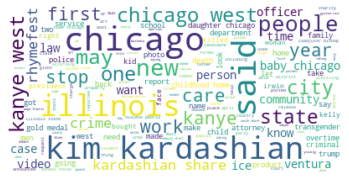

In [353]:
#Topic0
text = str(dat['cleaned_titlebody'][dat['topic']=="topic0"])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

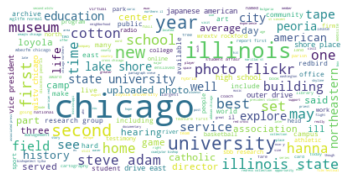

In [354]:
#Topic1
text = str(dat['cleaned_titlebody'][dat['topic']=="topic1"])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

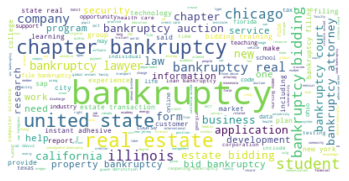

In [355]:
#Topic2
text = str(dat['cleaned_titlebody'][dat['topic']=="topic2"])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

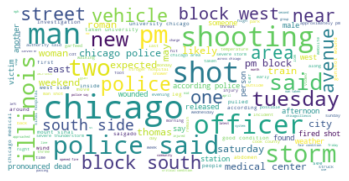

In [356]:
#Topic3
text = str(dat['cleaned_titlebody'][dat['topic']=="topic3"])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

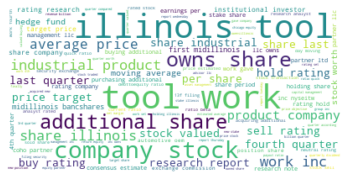

In [357]:
#Topic4
text = str(dat['cleaned_titlebody'][dat['topic']=="topic4"])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

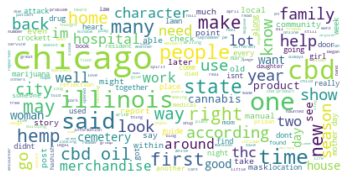

In [358]:
#Topic5
text = str(dat['cleaned_titlebody'][dat['topic']=="topic5"])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

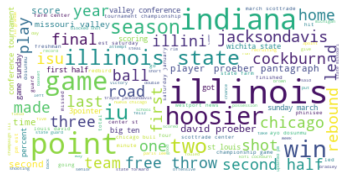

In [359]:
#Topic6
text = str(dat['cleaned_titlebody'][dat['topic']=="topic6"])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

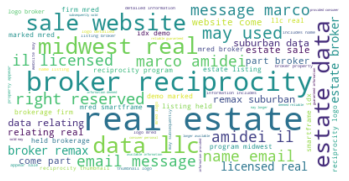

In [360]:
#Topic7
text = str(dat['cleaned_titlebody'][dat['topic']=="topic7"])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

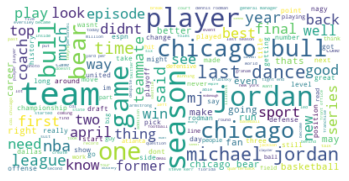

In [361]:
#Topic8
text = str(dat['cleaned_titlebody'][dat['topic']=="topic8"])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

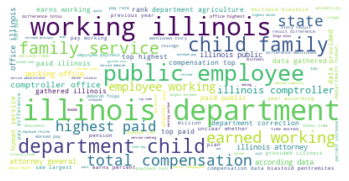

In [362]:
#Topic9
text = str(dat['cleaned_titlebody'][dat['topic']=="topic9"])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Create a set for just articles mentioning population declines / population changes
Keywords are selected by using most similar words above

In [405]:
pop_keys=("population", "demographic", "migration", "census", "decline", "historically","poverty", "rural", "declining", "decline", "economic",'resident','citizen','populace','community')
#selected based on most similar words above
pop_dat=dat[dat['cleaned_titlebody'].str.contains('|'.join(pop_keys), case=False)]

In [406]:
pop_dat.shape

(23472, 39)

Look at the top topics of this subset. From this we can see which topics are actually related to population changes in chicago/illinois

In [402]:
pop_dat['topic'].value_counts()

topic0    6153
topic1    3969
topic2    3634
topic5    2820
topic9    2484
topic3    2159
topic8    1097
topic4    908 
topic6    234 
topic7    14  
Name: topic, dtype: int64

### NER

In [113]:
nlp=en_core_web_sm.load()

In [114]:
doc=nlp(str(dat['title_body']))

In [115]:
entities = []
labels = []
position_start = []
position_end = []

for ent in doc.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
    
test = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})

test.head()

Entities    Labels  Position_Start  Position_End
0  (2)                           CARDINAL  0               1           
1  (Friday)                      DATE      15              21          
2  (Alton)                       ORG       23              28          
3  (Illinois, Gloria, Lawrence)  ORG       30              54          
4  (May, 10, ,, 2020)            DATE      61              73

In [116]:
Counter(labels)

Counter({'CARDINAL': 222,
         'DATE': 230,
         'ORG': 376,
         'LOC': 52,
         'GPE': 420,
         'TIME': 42,
         'FAC': 33,
         'ORDINAL': 29,
         'PERSON': 272,
         'PRODUCT': 26,
         'EVENT': 8,
         'WORK_OF_ART': 16,
         'MONEY': 42,
         'LAW': 85,
         'NORP': 35,
         'PERCENT': 1,
         'QUANTITY': 11})

Look at most common in a couple groups. The ones we'll specifically target are organizations (businesses) and people

In [117]:
org_ct = [x.text for x in doc.ents if x.label_ == "ORG"]

In [118]:
Counter(org_ct).most_common(20)

[('United', 15),
 ('Bulls', 6),
 ('NBA', 6),
 ('MOVEAUTO', 5),
 ('A&R', 4),
 ('CTA', 4),
 ('EDS', 3),
 ('Premier League', 3),
 ('Chicago Bulls', 3),
 ('ESPN', 3),
 ('Eversley', 3),
 ('Illinois Edition', 3),
 ('COPA', 3),
 ('the University of Chicago Medical Center', 2),
 ('the University of Chicago Hospital', 2),
 ('AP', 2),
 ('irs', 2),
 ('Manchester United', 2),
 ('Old Trafford', 2),
 ('Nike', 2)]

In [119]:
gpe_ct = [x.text for x in doc.ents if x.label_ == "GPE"]

In [120]:
Counter(gpe_ct).most_common(20)

[('Chicago', 83),
 ('United States', 28),
 ('Illinois', 16),
 ('chicago', 9),
 ('detroit', 8),
 ('california', 8),
 ('California', 7),
 ('michigan', 5),
 ('new york', 4),
 ('Oregon', 4),
 ('Florida', 4),
 ('georgia', 4),
 ('New York', 4),
 ('us', 3),
 ('Mount Sinai', 3),
 ('maryland', 3),
 ('Oklahoma', 3),
 ('florida', 3),
 ('canada', 3),
 ('ohio', 3)]

In [121]:
PERSON_ct = [x.text for x in doc.ents if x.label_ == "PERSON"]

In [122]:
Counter(PERSON_ct).most_common(20)

[('Trubisky', 6),
 ('Roman', 6),
 ('Tolani Baj', 4),
 ('Manchester United', 4),
 ('Miller', 4),
 ('Jackson', 4),
 ('McDonough', 4),
 ('Pedro', 3),
 ('Nigerian Vblogger', 3),
 ('Lindsay', 3),
 ('U.C. Davis', 3),
 ('Willian', 2),
 ('Zach LaVine', 2),
 ('Forbes', 2),
 ('Mitchell Trubisky', 2),
 ('Mack', 2),
 ('Eddie Jackson', 2),
 ('Marc Eversley', 2),
 ('Arturas Karnisovas', 2),
 ('Sidney', 2)]

Add NER to the original document

In [263]:
def extract_named_ents(text):
    """Extract named entities, and beginning, middle and end idx using spaCy's out-of-the-box model. 
    
    Keyword arguments:
    text -- the actual text source from which to extract entities
    
    """
    return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in nlp(text).ents]

def add_named_ents(df):
    """Create new column in data frame with named entity tuple extracted.
    
    Keyword arguments:
    df -- a dataframe object
    
    """
    df['named_ents'] = df['text'].apply(extract_named_ents)    

In [ ]:
org_ct = [x.text for x in doc.ents if x.label_ == "ORG"]

In [270]:
def extract_named_ents_org(text):
    """Extract named entities, and beginning, middle and end idx using spaCy's out-of-the-box model. 
    
    Keyword arguments:
    text -- the actual text source from which to extract entities
    
    """
    return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in nlp(text).ents  if ent.label_ == "ORG"]

def add_named_ents_org(df):
    """Create new column in data frame with named entity tuple extracted.
    
    Keyword arguments:
    df -- a dataframe object
    
    """
    df['named_ents_org'] = df['text'].apply(extract_named_ents_org)    

In [271]:
add_named_ents_org(dat)

In [274]:
def extract_named_ents_pers(text):
    """Extract named entities, and beginning, middle and end idx using spaCy's out-of-the-box model. 
    
    Keyword arguments:
    text -- the actual text source from which to extract entities
    
    """
    return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in nlp(text).ents  if ent.label_ == "PERSON"]

def add_named_ents_pers(df):
    """Create new column in data frame with named entity tuple extracted.
    
    Keyword arguments:
    df -- a dataframe object
    
    """
    df['named_ents_pers'] = df['text'].apply(extract_named_ents_pers)    

In [275]:
add_named_ents_pers(dat)

In [276]:
dat.to_csv(r'dat_with_ner_org_pers.csv')

In [277]:
dat.shape

(108176, 15)

I'm going to tag each document true==1/false==0 if there are mentions of the most common organizations and persons

In [293]:
#Org-United
kw=['United']
dat['United']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [295]:
#Org-Bulls
kw=['Bulls']
dat['Bulls']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [297]:
#Org-NBA
kw=['NBA']
dat['NBA']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [303]:
#Org-MOVEAUTO
kw=['MOVEAUTO']
dat['MOVEAUTO']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [305]:
#Org-A&R
kw=['A&R']
dat['AR']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [308]:
#Org-A&R
kw=['CTA']
dat['CTA']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [310]:
#Org-A&R
kw=['EDS']
dat['EDS']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [312]:
#Org-PremierLeague
kw=['Premier League']
dat['PremierLeague']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [ ]:
#Org-PremierLeague
kw=['Premier League']
dat['PremierLeague']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [313]:
#Org-ESPN
kw=['ESPN']
dat['ESPN']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [314]:
#Org-Eversley
kw=['Eversley']
dat['Eversley']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [340]:
#Org-Eversley
kw=['Illinois Edition']
dat['IllinoisEdition']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [316]:
#Org-Eversley
kw=['COPA']
dat['COPA']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [317]:
#Pers-Trubisky
kw=['Trubisky']
dat['Trubisky']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [318]:
#Pers-Roman
kw=['Roman']
dat['Roman']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [319]:
#Pers-Tolani Baj
kw=['Tolani Baj']
dat['TolaniBaj']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [320]:
#Pers-Manchester united
kw=['Manchester United']
dat['ManchesterUnited']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [321]:
#Pers-Miller
kw=['Miller']
dat['Miller']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [322]:
#Pers-Jackson
kw=['Jackson']
dat['Jackson']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [324]:
#Pers-mcdonough
kw=['McDonough']
dat['McDonough']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [323]:
#Pers-Pedro
kw=['Pedro']
dat['Pedro']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [325]:
#Pers-Nigerian
kw=['Nigerian Vblogger']
dat['nigeran']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

In [326]:
#Pers-Lindsay
kw=['Lindsay']
dat['Lindsay']=dat['title_body'].apply(lambda x: any([k in x for k in kw]))

### Sentiment tuning

As mentioned above, the results of the off-the-shelf packages aren't great. I'll try manually coding ~1k, then creating a supervised machine learning model to tag sentiment. That way, the sentiment scoring will be more customized for this specific dataset.
Manually classify a sample of data where -1 = negative sentiment, 0 = neutral, and 1 = positive

In [126]:
import random
sampled_dat = random.sample(list(dat['text']), 5000)

In [128]:
pd.DataFrame(sampled_dat).to_csv(r'sample_for_sentiment.csv', index=False)

In [230]:
sent_dat=pd.read_csv(r'sample_for_sentiment_coded - sample_for_sentiment_coded-7.csv')

In [231]:
#Concatenate title and aritcle body
sent_dat['Comment']=sent_dat['Comment'].astype(str)

In [232]:
#lowercase
sent_dat['Comment_new'] = sent_dat['Comment'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [233]:
#lowercase
sent_dat['Comment_new'] = sent_dat['Comment'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#remove punctuation
sent_dat['Comment_new'] = sent_dat['Comment_new'].str.replace('[^\w\s]','')

#remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
sent_dat['Comment_new'] = sent_dat['Comment_new'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#lemmatization
from textblob import Word
sent_dat['Comment_new'] = sent_dat['Comment_new'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [234]:
sent_dat['Sentiment'].value_counts()

 0    880
-1    305
 1    214
Name: Sentiment, dtype: int64

Supervised ML on sentiment

In [235]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction import DictVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import datasets,ensemble

In [236]:
tfidf_vectorizer=feature_extraction.text.TfidfVectorizer()
train_vectors=tfidf_vectorizer.fit_transform(sent_dat['Comment_new'])

In [237]:
y=sent_dat['Sentiment']
x=train_vectors
oversample=SMOTE()
x,y=oversample.fit_resample(x,y)

In [238]:
(x_train, x_test, y_train, y_test)=train_test_split(x,y,test_size=0.1)

In [239]:
#Naive Bayes
naive_bayes=MultinomialNB()
naive_bayes.fit(x_train, y_train)
y_pred=naive_bayes.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[88  1  2]
 [ 8 36 33]
 [ 1  0 95]]
              precision    recall  f1-score   support

          -1       0.91      0.97      0.94        91
           0       0.97      0.47      0.63        77
           1       0.73      0.99      0.84        96

    accuracy                           0.83       264
   macro avg       0.87      0.81      0.80       264
weighted avg       0.86      0.83      0.81       264



In [240]:
#Decision Tree
dt=DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred=dt.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


[[72 12  7]
 [10 57 10]
 [ 3 12 81]]
              precision    recall  f1-score   support

          -1       0.85      0.79      0.82        91
           0       0.70      0.74      0.72        77
           1       0.83      0.84      0.84        96

    accuracy                           0.80       264
   macro avg       0.79      0.79      0.79       264
weighted avg       0.80      0.80      0.80       264



In [241]:
#Random Forest
rf=RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred=rf.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[78 12  1]
 [11 63  3]
 [ 1  9 86]]
              precision    recall  f1-score   support

          -1       0.87      0.86      0.86        91
           0       0.75      0.82      0.78        77
           1       0.96      0.90      0.92        96

    accuracy                           0.86       264
   macro avg       0.86      0.86      0.86       264
weighted avg       0.86      0.86      0.86       264



In [242]:
#GradientBoosing
gb=ensemble.GradientBoostingClassifier()
gb.fit(x_train, y_train)
y_pred=gb.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[75 14  2]
 [ 6 65  6]
 [ 0 13 83]]
              precision    recall  f1-score   support

          -1       0.93      0.82      0.87        91
           0       0.71      0.84      0.77        77
           1       0.91      0.86      0.89        96

    accuracy                           0.84       264
   macro avg       0.85      0.84      0.84       264
weighted avg       0.86      0.84      0.85       264



Looks like random forest is the best model, will apply that to the rest of the full dataset

In [243]:
test_vectors=tfidf_vectorizer.transform(dat["cleaned_titlebody"])

In [244]:
test_ypred=rf.predict(test_vectors)

Assign positive, netural, negative sentiment to each article (row)

In [245]:
dat['rf_sent']=list(test_ypred)

check a couple records on the full dataset to make sure nothing is too off

In [246]:
dat.tail()

crawled_date language  \
177306 2020-04-29    english   
177310 2020-04-29    english   
177315 2020-04-29    english   
177318 2020-04-29    english   
177323 2020-04-29    english   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [247]:
dat['rf_sent'].value_counts()

 0    64339
-1    29588
 1    14249
Name: rf_sent, dtype: int64

Review sentiment by topic again. This is showing better insights now.

In [248]:
pd.crosstab(dat.topic, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
topic                                   
topic0   52.516428  37.155006  10.328566
topic1   12.510633  73.061572  14.427796
topic2   20.229416  59.249538  20.521046
topic3   62.814283  35.417987  1.767730 
topic4   1.768397   97.347404  0.884199 
topic5   20.051829  58.761979  21.186192
topic6   15.299846  68.580215  16.119938
topic7   0.032621   99.967379  0.000000 
topic8   27.163302  51.985594  20.851104
topic9   23.591349  68.952760  7.455891

Looks like topics 0, 3 are particularly negative
Topics 4, 7 are especially neutral

NER vs. sentiment. I'll look at % positive, neutral, negative sentiment for top organizations and people

In [329]:
pd.crosstab(dat.United, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
United                                  
False    27.376035  60.265390  12.358575
True     27.045054  49.521772  23.433174

In [330]:
pd.crosstab(dat.Bulls, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
Bulls                                   
False    27.483902  59.699499  12.816599
True     23.216950  52.491793  24.291256

In [331]:
pd.crosstab(dat.NBA, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
NBA                                     
False    27.305022  60.004179  12.690799
True     29.050086  40.276339  30.673575

In [332]:
pd.crosstab(dat.MOVEAUTO, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent          -1           0          1
MOVEAUTO                                  
False     27.351976  59.475849   13.172175
True      0.000000   100.000000  0.000000

In [333]:
pd.crosstab(dat.AR, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent        -1          0          1
AR                                     
False    27.35501  59.477825  13.167164
True     0.00000   46.153846  53.846154

In [334]:
pd.crosstab(dat.CTA, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
CTA                                     
False    27.160390  59.745968  13.093642
True     53.426396  22.715736  23.857868

In [335]:
pd.crosstab(dat.EDS, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
EDS                                     
False    27.345730  59.484689  13.169581
True     34.883721  48.837209  16.279070

In [336]:
pd.crosstab(dat.PremierLeague, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent              -1         0         1
PremierLeague                              
False          27.35575  59.47944  13.16481
True           23.00000  56.00000  21.00000

In [337]:
pd.crosstab(dat.ESPN, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
ESPN                                    
False    27.316104  59.770147  12.913749
True     29.886591  38.559039  31.554370

In [338]:
pd.crosstab(dat.Eversley, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent          -1          0          1
Eversley                                 
False     27.351257  59.483181  13.165561
True      28.301887  45.283019  26.415094

In [341]:
pd.crosstab(dat.IllinoisEdition, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent                 -1           0          1
IllinoisEdition                                  
False            27.352229  59.475475   13.172296
True             0.000000   100.000000  0.000000

In [342]:
pd.crosstab(dat.COPA, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
COPA                                    
False    27.296362  59.521298  13.182340
True     92.391304  6.521739   1.086957

In [343]:
pd.crosstab(dat.Trubisky, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent          -1          0          1
Trubisky                                 
False     27.219029  59.689937  13.091034
True      44.246738  32.265718  23.487544

In [344]:
pd.crosstab(dat.Roman, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
Roman                                   
False    27.247393  59.721691  13.030916
True     40.000000  29.717514  30.282486

In [345]:
pd.crosstab(dat.TolaniBaj, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent           -1          0          1
TolaniBaj                                 
False      27.352987  59.475275  13.171737
True       0.000000   80.000000  20.000000

In [346]:
pd.crosstab(dat.ManchesterUnited, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent                  -1          0          1
ManchesterUnited                                 
False             27.347384  59.481555  13.171061
True              37.777778  46.666667  15.555556

In [347]:
pd.crosstab(dat.Miller, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
Miller                                  
False    27.228963  59.776777  12.994261
True     38.313856  32.637730  29.048414

In [348]:
pd.crosstab(dat.Jackson, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
Jackson                                 
False    27.029505  60.116093  12.854401
True     41.558983  31.263026  27.177991

In [349]:
pd.crosstab(dat.Pedro, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
Pedro                                   
False    27.330044  59.524317  13.145640
True     41.717791  27.607362  30.674847

In [350]:
pd.crosstab(dat.McDonough, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent           -1          0          1
McDonough                                 
False      27.343208  59.498191  13.158601
True       37.931034  32.183908  29.885057

In [351]:
pd.crosstab(dat.nigeran, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1           0          1
nigeran                                  
False    27.352229  59.475475   13.172296
True     0.000000   100.000000  0.000000

In [352]:
pd.crosstab(dat.Lindsay, dat.rf_sent).apply(lambda r: r/r.sum()*100, axis=1)

rf_sent         -1          0          1
Lindsay                                 
False    27.347611  59.499658  13.152731
True     30.769231  40.000000  29.230769

Use wordclouds to visualize top organizations and people

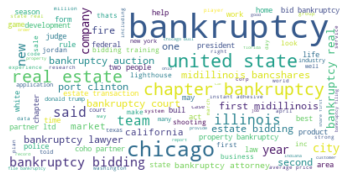

In [366]:

text = str(dat['cleaned_titlebody'][dat['United']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

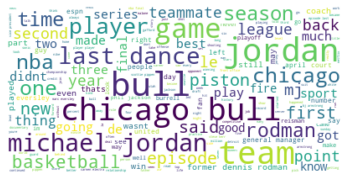

In [367]:
#'Bulls', 'NBA', 'MOVEAUTO', 'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['Bulls']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

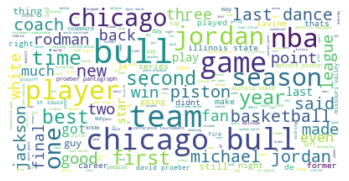

In [368]:
#'Bulls', 'NBA', 'MOVEAUTO', 'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['NBA']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

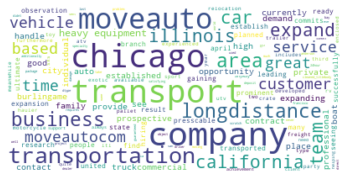

In [369]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['MOVEAUTO']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

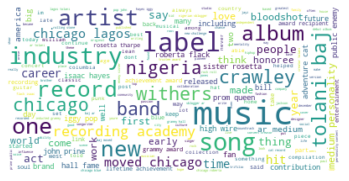

In [370]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['AR']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

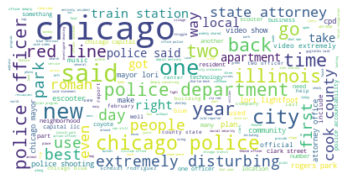

In [371]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['CTA']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

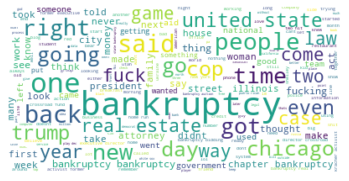

In [372]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['EDS']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

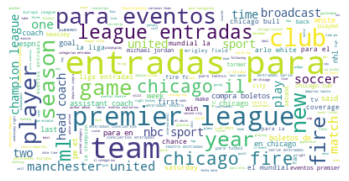

In [373]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['PremierLeague']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

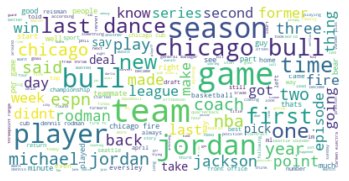

In [374]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['ESPN']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

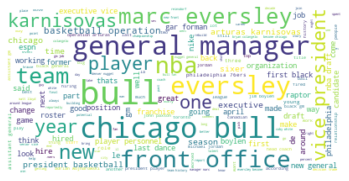

In [375]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['Eversley']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

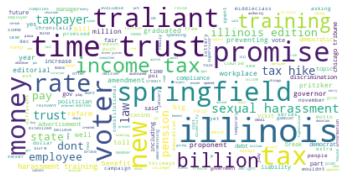

In [376]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['IllinoisEdition']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

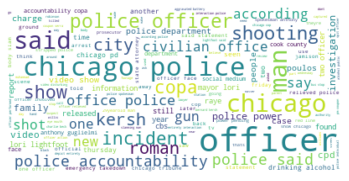

In [377]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['COPA']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

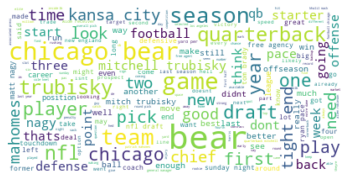

In [378]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['Trubisky']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

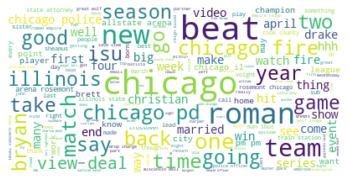

In [379]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['Roman']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

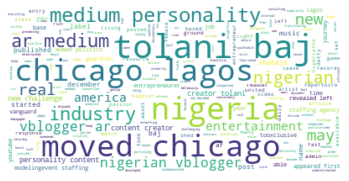

In [380]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['TolaniBaj']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

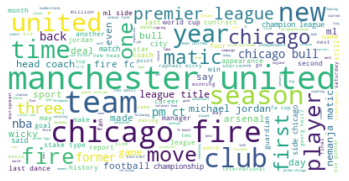

In [381]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['ManchesterUnited']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

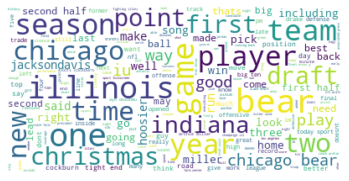

In [382]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['Miller']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

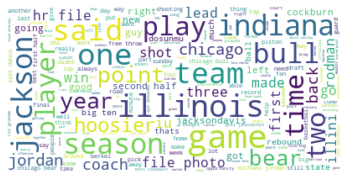

In [383]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['Jackson']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

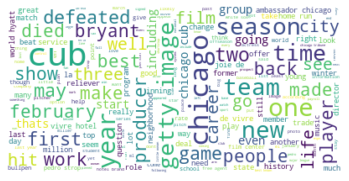

In [384]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['Pedro']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

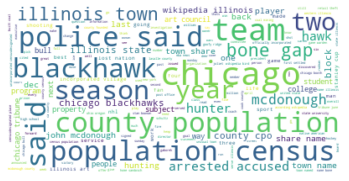

In [385]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['McDonough']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

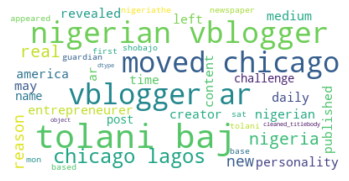

In [386]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['nigeran']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

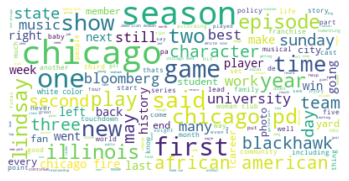

In [387]:
#'AR', 'CTA', 'EDS',
#       'Premier League', 'PremierLeague', 'ESPN', 'Eversley',
#       'Illinois Edition', 'COPA', 'Trubisky', 'Roman', 'TolaniBaj',
#       'ManchesterUnited', 'Miller', 'Jackson', 'Pedro', 'McDonough',
#       'nigeran', 'Lindsay', 'IllinoisEdition'
        
text = str(dat['cleaned_titlebody'][dat['Lindsay']==True])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()